In this short "draft" I'll use GAN implementation from https://habrahabr.ru/post/332000/ on :
- MNIST - this'll be samples from "normal" distribution
- normal random noise - this'll be samples from other distribution

So I'll try to predict - are image comes from "normal" or "anomaly" distribution by output of dicriminator network (of GAN that's trained on MNIST without anomaly samples).

# GAN implementation/train
Firstly let's initialize imports

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model


from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

Using TensorFlow backend.


In [2]:
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [3]:
batch_size = 256
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 2
num_classes = 10
dropout_rate = 0.3

In [4]:
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]


train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)

In [5]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),   name='image')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim),  name='z')

img = Input(tensor=x_)
z   = Input(tensor=z_)

In [7]:
with tf.variable_scope('generator'):
    x = z
    x = Dense(7*7*64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = UpSampling2D(size=(2, 2))(x)

    generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
generator = Model(z, generated, name='generator')

In [8]:
with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    
    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model(img, d, name='Discriminator')

In [10]:
generated_z = generator(z)

discr_img   = discrim(img)
discr_gen_z = discrim(generated_z)

gan_model = Model(z, discr_gen_z, name='GAN')
gan   = gan_model(z)

In [11]:
log_dis_img   = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5*(log_dis_gen_z + log_dis_img)

In [12]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

# Переменные генератора и дискриминаторы (отдельно) для оптимизаторов
generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
discrim_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

In [13]:
sess.run(tf.global_variables_initializer())

In [16]:
# Шаг обучения генератора
def step(image, zp):
    l_dis, _ = sess.run([L_dis, step_gen], feed_dict={z:zp, img:image, K.learning_phase():1})
    return l_dis

# Шаг обучения дискриминатора
def step_d(image, zp):
    l_dis, _ = sess.run([L_dis, step_dis], feed_dict={z:zp, img:image, K.learning_phase():1})
    return l_dis

In [ ]:
batches_per_period = 20 # Как часто сохранять картинки
k_step = 5 # Количество шагов, которые могут делать дискриминатор и генератор во внутреннем цикле

for i in range(5000):
    # Достанем новый батч
    b0, b1 = next(train_batches_it)
    zp = np.random.randn(batch_size, latent_dim)
    # Шаги обучения дискриминатора
    for j in range(k_step):
        l_d = step_d(b0, zp)
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

    # Шаги обучения генератора
    for j in range(k_step):
        l_d = step(b0, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

# Test
Now I'll make next things:
- build discriminator prediction for test part of MNIST
- generate random noise "images" - and build discriminator prediction for noise
- see histograms of discriminator output for test set / noise
- concatenate both predictions and check F1 score, where:
    - true values - 1.0 for noise samples, 0.0 for test set samples
    - predicted values:
        - 1.0 if abs(D(sample) - 0.5) > 0.2, where 0.5/0.2 - some thresholds - which'll be hyperperemeters of algorythm. I used 0.5 - because seems like it'll be "optimal" output for discriminator that's unable to differentiate - are sample goes from MNIST or from generator.
        - else 0.0

In [43]:
test_predictions = []
i = 0
for X, _ in gen_batch(x_test,  y_test_cat):
    test_predictions += sess.run(discr_img, {img: X, K.learning_phase():0}).ravel().tolist()
    i += 1
    if i == 39:
        break

In [47]:
noise = np.random.randn(256, 28, 28, 1)
noise.shape

(256, 28, 28, 1)

In [48]:
noise_prediction = sess.run(discr_img, {img: noise, K.learning_phase():0}).ravel().tolist()

In [49]:
test_predictions = np.array(test_predictions)
noise_prediction = np.array(noise_prediction)

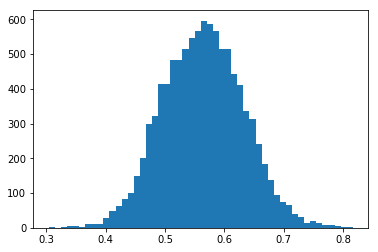

In [52]:
plt.hist(test_predictions, bins=50);

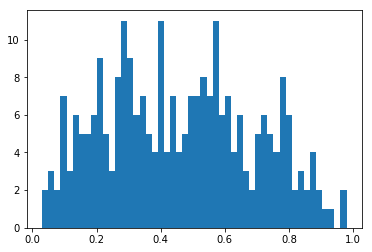

In [53]:
plt.hist(noise_prediction, bins=50);

In [54]:
from sklearn.metrics import f1_score

In [78]:
y_pred = np.hstack([test_predictions, noise_prediction])
y_pred_dist = np.abs(y_pred - 0.5)
y_pred_anomaly = y_pred_dist > 0.2
y_test = np.array([[0] * len(test_predictions) + [1] * len(noise_prediction)]).ravel()

In [79]:
f1_score(y_test, y_pred_anomaly)

0.4173354735152488

As you can see - discriminator prediction distributions for samples from MNIST and noise are very different - so we have relativelly good F1-score.
Let's check count of false-positives and false-negatives:

In [81]:
print("False positives: ", np.logical_and(np.logical_not(y_test), y_pred_anomaly).sum())

False positives:  237


In [82]:
print("False negatives: ", np.logical_and(y_test, np.logical_not(y_pred_anomaly)).sum())

False negatives:  126
